# Imports





In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 23 12:37:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from google.colab import files
from scipy.spatial.distance import squareform
from sklearn import preprocessing
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch import optim
import copy
import random
from collections import defaultdict
import math
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler

In [ ]:
# Connect to google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set up device to run models on GPU
device = 'cuda'

#Data Analysis

In [ ]:
# Upload files from local machine.
uploaded = files.upload()

Saving log_mini.csv to log_mini.csv


In [ ]:
# Load in datasets
data_track_attr = pd.read_csv("/content/tf_mini.csv")
data_sessions = pd.read_csv("/content/log_mini.csv")

In [ ]:
# Song Metadata Dataset
data_track_attr.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,0.903753,3.254327e-06,0,0.132124,-11.238,0.386100,major,0.541606,0.079985,166.287003,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,1.037952,8.344854e-12,0,0.163281,-13.706,0.125000,major,0.895874,0.083877,95.261002,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,1.004268,2.927475e-10,0,0.090115,-10.522,0.200669,minor,0.806136,0.038777,105.185997,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,0.975138,3.981341e-11,0,0.360924,-11.032,0.427152,major,0.492772,0.038337,119.441002,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,0.976866,2.541884e-10,0,0.189162,-6.836,0.281250,major,0.723808,0.032043,95.261002,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


In [ ]:
# Listening Session Dataset
data_sessions.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [ ]:
# Counts of session lengths
data_sessions.drop_duplicates(['session_id'])['session_length'].value_counts()

20    5066
10     819
11     752
12     646
13     547
14     459
15     435
16     339
17     320
19     314
18     303
Name: session_length, dtype: int64

In [ ]:
# Ensure all songs are represented in the session dataset
len(list(data_sessions['track_id_clean'].unique()))

50704

Text(0, 0.5, 'Value Count')

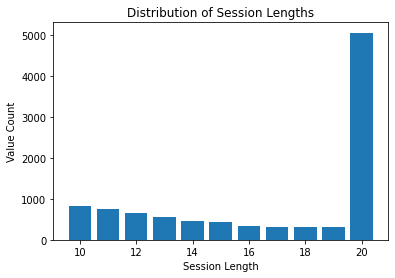

In [ ]:
# Plot counts of session length.
plt.bar(data_sessions.drop_duplicates(['session_id'])['session_length'].value_counts().index.tolist(), data_sessions.drop_duplicates(['session_id'])['session_length'].value_counts().values)
plt.title('Distribution of Session Lengths')
plt.xlabel('Session Length')
plt.ylabel('Value Count')

In [ ]:
# Calculate not-skip rate in sessions dataset
print(data_sessions['not_skipped'].value_counts())
print("Not-skipped rate: ", 55884/167880)

False    111996
True      55884
Name: not_skipped, dtype: int64
Not-skipped rate:  0.33288062902072907


# Data Pre-processing 

In [ ]:
# Create copy of song feature dataset to do normalization
data_track_attr_copy = copy.deepcopy(data_track_attr.loc[:, data_track_attr.columns != 'track_id'])

In [ ]:
# Get rid of features due to low variability within dataset
data_track_attr_copy = data_track_attr_copy.drop(columns=['key', 'mode', 'time_signature'])

In [ ]:
# Make skip values numerical.
data_sessions[data_sessions['not_skipped'] == 'True'] = 1
data_sessions[data_sessions['not_skipped'] == 'False'] = 0

In [ ]:
# create a scaler object. This is to scale song metadata features
std_scaler = StandardScaler().fit_transform(data_track_attr_copy)
track_data_std = pd.DataFrame(std_scaler, index=data_track_attr_copy.index, columns=data_track_attr_copy.columns)
track_data_std['track_id'] = data_track_attr['track_id']
track_data_std

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,liveness,loudness,mechanism,organism,speechiness,tempo,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,track_id
0,-1.558500,-5.258547,0.456705,0.752430,0.173446,-0.052451,-1.275852,-0.292072,0.847631,-2.034497,-0.329484,-0.415877,-0.946756,-0.721635,0.722943,-0.316225,1.501039,1.817189,0.718232,-2.417470,-0.858259,1.170620,2.277672,-1.826212,-0.290724,-2.100378,t_a540e552-16d4-42f8-a185-232bd650ea7d
1,-0.478713,-5.258547,0.451451,2.412423,-0.460794,0.169800,-0.725316,0.366060,-2.342727,0.907773,-0.329500,-0.239334,-1.575094,-1.888302,2.433443,-0.287611,-0.883469,-0.520061,1.148162,-4.143609,-0.141429,2.363765,1.057219,-3.259505,-0.043913,-1.637434,t_67965da0-132b-4b1e-8a69-0ef99b32287c
2,-0.850519,-5.171376,0.129403,2.037889,-0.418624,-0.034208,-0.722973,0.063354,-1.359077,0.169251,-0.329500,-0.653912,-0.764466,-1.550193,2.000166,-0.619176,-0.550264,0.969928,0.850351,-3.723416,0.843197,1.828058,1.161314,-1.645059,-0.542656,-1.352784,t_0614ecd3-a7d5-40a1-816e-156d5872a467
3,-0.648924,-5.171376,0.184238,0.530778,-0.576471,-0.846341,-0.358213,-0.932798,-0.610010,-0.469397,-0.329500,0.880555,-0.894309,-0.538204,0.487159,-0.622410,-0.071690,1.506940,0.892203,-1.849248,-0.967569,0.440372,1.701064,-1.115742,-0.194933,-1.689731,t_070a63a0-744a-434e-9913-a97b02926a29
4,2.039928,-5.171376,0.471056,1.733399,-0.763730,-0.982573,-0.774619,-1.001107,0.384709,-0.431531,-0.329500,-0.092689,0.173968,-1.190135,1.602665,-0.668686,-0.883469,0.302542,1.115082,-1.947536,-1.545933,0.018321,1.972366,-0.455706,-0.557220,-1.420633,t_d6990e17-9c31-4b01-8559-47d9ce476df1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50699,-0.520341,0.669057,-0.122160,1.211505,0.186397,0.003071,0.249170,-0.220580,-1.466699,1.012459,-0.325469,-0.584413,-0.840335,0.223228,0.531475,-0.628723,-0.961826,0.220231,0.327382,0.391836,0.399443,-1.053342,0.116403,1.371390,-0.576353,-0.609476,t_402930af-4174-47ec-b1fd-593d93597624
50700,0.409079,0.669057,0.406809,0.566374,0.462524,0.978134,1.403108,1.228279,0.325287,-0.185340,-0.329488,-0.536178,0.395465,0.161339,0.094821,1.428411,0.087040,-0.062715,-0.511308,0.273219,0.566362,0.253589,-0.783406,0.702665,1.020866,1.169393,t_e5f9a069-a893-452e-ab21-49b4eaebfbd0
50701,-0.896487,0.669057,-0.822885,-0.902235,-0.489267,-0.946134,-0.891995,-1.165883,1.606422,-2.772818,-0.328906,0.653303,1.139389,-0.690080,0.179736,-0.453637,-0.484093,1.131266,1.068629,0.654791,-2.919649,-1.284707,1.767995,0.008987,-0.175055,0.782140,t_3983306d-13b4-4027-9391-7236ca93d2bf
50702,-1.289910,0.669057,0.393021,-0.401689,1.241616,1.200452,1.439812,1.063042,0.118809,1.211828,-0.329500,-0.567614,0.556369,1.113816,-1.050883,-0.394294,0.419372,-1.742470,-1.256250,0.642836,0.560050,0.446737,-0.474117,-0.288674,-0.601620,0.427057,t_74eb6e99-210b-440c-8d7b-4db6617d1c80


In [ ]:
# Get unique listening session ids
session_ids = data_sessions['session_id'].unique()

# Split sessions intro training and test sets
session_ids_training = session_ids[:int(len(session_ids)*0.8)]
session_ids_test = session_ids[int(len(session_ids)*0.8):]

# Get the first song in every session
data_sessions_training = data_sessions.loc[data_sessions['session_position'].isin([1])]

training_set_numeric = []
test_set_numeric = []

# For each session get the track id in order to get the features of that track
# for training set
for session in session_ids_training:
  songs = data_sessions_training.loc[data_sessions_training['session_id'] == session]['track_id_clean']
  songs_in_playlist = []
  for song in songs:
    songs_in_playlist.append(track_data_std.loc[track_data_std['track_id'] == song, track_data_std.columns != 'track_id'].to_numpy())
  
  training_set_numeric.append(songs_in_playlist)


# For each session get the track id in order to get the features of that track
# for test set
for session in session_ids_test:
  songs = data_sessions_training.loc[data_sessions_training['session_id'] == session]['track_id_clean']
  songs_in_playlist = []
  for song in songs:
    songs_in_playlist.append(track_data_std.loc[track_data_std['track_id'] == song, track_data_std.columns != 'track_id'].to_numpy())
  
  test_set_numeric.append(songs_in_playlist)



In [ ]:
# Get the first three songs in every session
data_sessions_training_multi = data_sessions.loc[data_sessions['session_position'].isin([1,2,3])]

training_set_numeric_multi = []
test_set_numeric_multi = []

# For each session get the track id in order to get the features of that track
for session in session_ids_training:
  songs = data_sessions_training_multi.loc[data_sessions_training_multi['session_id'] == session]['track_id_clean']
  songs_in_playlist = []
  for song in songs:
    songs_in_playlist.append(track_data_std.loc[track_data_std['track_id'] == song, track_data_std.columns != 'track_id'].to_numpy())
  
  training_set_numeric_multi.append(songs_in_playlist)

# For each session get the track id in order to get the features of that track
# for test set
for session in session_ids_test:
  songs = data_sessions_training_multi.loc[data_sessions_training_multi['session_id'] == session]['track_id_clean']
  songs_in_playlist = []
  for song in songs:
    songs_in_playlist.append(track_data_std.loc[track_data_std['track_id'] == song, track_data_std.columns != 'track_id'].to_numpy())
  
  test_set_numeric_multi.append(songs_in_playlist)


In [ ]:
# Convert each song features array to torach tensor
for seq in training_set_numeric:
  for song in seq:
    song = torch.from_numpy(song).float()

for seq in test_set_numeric:
  for song in seq:
    song = torch.from_numpy(song).float()

In [ ]:
# Convert list to torch FloatTensor
training_set_numeric = torch.FloatTensor(training_set_numeric)
test_set_numeric = torch.FloatTensor(test_set_numeric)

In [ ]:
# Squeeze the dimension
training_set_numeric = torch.squeeze(training_set_numeric)
test_set_numeric = torch.squeeze(test_set_numeric)

In [ ]:
# Validate tensor shape 
print(training_set_numeric.shape)
print(test_set_numeric.shape)

torch.Size([8000, 26])
torch.Size([2000, 26])


In [ ]:
# Convert each song features array to torach tensor
for seq in training_set_numeric_multi:
  for song in seq:
    song = torch.from_numpy(song).float()

for seq in test_set_numeric_multi:
  for song in seq:
    song = torch.from_numpy(song).float()

In [ ]:
# Convert list to torch FloatTensor
training_set_numeric_multi = torch.FloatTensor(training_set_numeric_multi)
test_set_numeric_multi = torch.FloatTensor(test_set_numeric_multi)

In [ ]:
# Squeeze the dimension
training_set_numeric_multi = torch.squeeze(training_set_numeric_multi)
test_set_numeric_multi = torch.squeeze(test_set_numeric_multi)

In [ ]:
# Validate tensor shape 
print(training_set_numeric_multi.shape)
print(test_set_numeric_multi.shape)

torch.Size([8000, 3, 26])
torch.Size([2000, 3, 26])


In [ ]:
# Convert song metadata to torch FloatTensor
track_data_std_tensor = torch.FloatTensor(track_data_std.loc[:, track_data_std.columns != 'track_id'].to_numpy())

# Helper Functions

In [ ]:
# Gets similar songs based upon a similarity score. If a song is within one 
# standard deviation from the similarity score of the song with itself 
# it is considered a closely related song. For computation reasons similar songs
# are capped at k songs.
def get_similar_songs(state):
  similar_songs = []
  distances = F.cosine_similarity(state.unsqueeze(0), track_data_std_tensor)
  
  similar_songs = torch.topk(distances, 25).indices

  return similar_songs


In [ ]:
song_ids = list(track_data_std['track_id'].values)

# Gets similar songs based upon a similarity score. Then finds all instances
# of each song within the session dataset and then compares the action song
# with the next song that was recommended in the session. If they are within one 
# std away their not-skip value is taken into account and a weight of their similarity
# with the action song is recorded. A weighted average is taken of the not-skip
# values and similarity weights to determine a non-skip probability.
def get_not_skip_prob(state, action_song_id):
  weights = []
  values = []
  similar_song_ids = get_similar_songs(state)
  similar_song_ids = [song_ids[i] for i in similar_song_ids]

  distances_action = F.cosine_similarity(track_data_std_tensor[action_song_id].unsqueeze(0), track_data_std_tensor)
  std_actions = torch.std(distances_action)
  lower_bound = 1 - std_actions

  for song_id in similar_song_ids:
    similar_states = data_sessions.loc[data_sessions['track_id_clean'] == song_id].index.tolist()
    for index in similar_states:
      if (index < 167879):
        new_index = index + 1
      else: new_index = index

      ref_action_id = data_sessions.loc[new_index, data_sessions.columns == 'track_id_clean'][0]
      ref_action_id = song_ids.index(ref_action_id)
      dist = distances_action[ref_action_id].item()
      if (dist > lower_bound):
        not_skip_value = data_sessions.loc[new_index, data_sessions.columns == 'not_skipped'][0]

        weights.append(dist)
        values.append(not_skip_value)

  
  prob = 0
  for x, y in zip(values, weights):
    prob += x * y

  if sum(weights) == 0:
    weights = [1]
  prob = prob / sum(weights)

  return prob
 


In [ ]:
# Calculates whether or not two songs are diverse from one another or not. 
# If the similarity value of the current and next song is more than 
# two std away from the similarity score of the current song with itself 
# then a diversity score of 1 is given and 0 if not. 
def get_song_dist_reward(state, action_song_id):
  reward = 0

  distances = F.cosine_similarity(state.unsqueeze(0), track_data_std_tensor)
  distances = torch.sub(torch.ones(len(distances)).to(device), distances)
  std = torch.std(distances).item()
  threshold = 0.4 * std

  distance = distances[action_song_id].item()

  if (distance > threshold):
    reward = 1

  return reward


In [ ]:
# Calculate discounted cumulative rewards
def discount_rewards(rewards, gamma):
    r = np.array([gamma**i * rewards[i] 
                  for i in range(len(rewards))])
 
    r = r[::-1].cumsum()[::-1]
  
    return r

# Torch Data Preparation

In [ ]:
# Push tensors to cuda if available
if torch.cuda.is_available():
  training_set_numeric = training_set_numeric.to(device)
  test_set_numeric = test_set_numeric.to(device)
  track_data_std_tensor = track_data_std_tensor.to(device)
  training_set_numeric_multi = training_set_numeric_multi.to(device)

#Agent

In [ ]:
# Model for REINFORCE implementation. This is the agent that will be trained to
# make decisions based upon the learned policy.
class Agent():
    def __init__(self, input_size=26, hidden_size=32, num_classes=50704, temp=1):
        super(Agent, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.ReLU(), 
            nn.Linear(hidden_size, num_classes))
        
    
    def forward(self, x):
        out = self.network(x)
        
        return out

# Actor-Critic Models

In [ ]:
# Model for A2C implementation. This is the agent that will be trained to
# make decisions based upon the learned policy. The output space is the length
# of the action space which is the number of unique songs.
class Actor():
    def __init__(self, input_size=26, hidden_size=32, num_actions=50704):
        super(Actor, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.ReLU(), 
            nn.Linear(hidden_size, num_actions))
        

    def forward(self, x):
        policy_distribution = self.network(x)
        
        return policy_distribution

In [ ]:
# Model for A2C implementation. This is the agent that will be trained to
# monitor and rate decisions of the actor based upon the learned policy. The 
# output space is a singular state value. 
class Critic():
    def __init__(self, input_size=26, hidden_size=32):
        super(Critic, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), 
            nn.ReLU(), 
            nn.Linear(hidden_size, 1))
        
    
    def forward(self, x):
        value = self.network(x)
        
        return value

# REINFORCE Training

Code for this section was modeled based off of the implementation found here: https://www.datahubbs.com/reinforce-with-pytorch/

In [ ]:
random.seed(1057)

In [ ]:
# Implementation of the REINFORCE algorithm to train the agent and 
# find an optimal policy.
def train(model, episodes=500, batch_size=1, gamma=0.99, multi=False, temp=1):

  # Initialize list for state, action, rewards for each episode
  total_rewards = []
  losses = []
  state_batch = []
  action_batch = []
  reward_batch = []
  total_skip_rewards = []
  batch_i = 0
  ep = 1

  # Initialize optimizer for agent
  optimizer = optim.Adam(model.network.parameters(), lr=0.0003)

  # For the amount of episodes run a simulation with trajectory length 20. 
  # Accumulate states, actions, and rewards from the episode.
  while ep <= episodes:
    # If using temperature scaling update the temperature value
    if ep != 0 and ep % 30 == 0 and temp != 0.1:
      temp -= 0.05
    states = []
    actions = []
    rewards = []
    skip_rewards = []

    i = random.randint(0,len(training_set_numeric)-1)

    if multi:
      state_multi = training_set_numeric_multi[i,:,:]
      state = torch.sum(state_multi, dim=0)
    else: 
      state = training_set_numeric[i]

    if torch.cuda.is_available():
          state = state.to(device)

    # Run simulation for 20 songs
    for song_i in range(20):
      output = model.forward(state).to(device)
      output = torch.div(output, temp)
      # Action probabilities
      output = F.softmax(output, dim=0) 

      # Choose an action based upon the action probabilities
      action_index = torch.multinomial(output, 1).item()

      # Calculate not-skip probability and diversity score
      not_skip_prob = get_not_skip_prob(state, action_index)
      #diversity_val = get_song_dist_reward(state, action_index)

      # Test to see if not-skip probability is higher 
      # than the not-skip rate of dataset
      if not_skip_prob > 0.33:
        skip_reward = 1
      else:
        skip_reward = 0
      
      # Calculate the reward
      #reward = (0.5 * not_skip_prob) + (0.5 * diversity_val)
      reward = not_skip_prob
  
      # Append states, actions, and rewards for current step
      states.append(state.cpu().detach().numpy())
      actions.append(action_index)
      rewards.append(reward)
      skip_rewards.append(skip_reward)

      # Update the state
      if multi:
        state = torch.cat((state_multi.unsqueeze(0)[:,1:,:], track_data_std_tensor[action_index].unsqueeze(0).unsqueeze(0)), dim=1)
        state = torch.sum(state_multi, dim=0)
      else:
        state = track_data_std_tensor[action_index].to(device)
 

    rewards_copy = copy.deepcopy(rewards)
    reward_batch.extend(discount_rewards(
                    rewards_copy, gamma))
    state_batch.extend(states)
    action_batch.extend(actions)
    batch_i += 1

    # Calculate the total reward for the episode
    total_rewards.append(sum(rewards))
    total_skip_rewards.append(sum(skip_rewards))

    # If batch is complete, update network
    if batch_i == batch_size:
        optimizer.zero_grad()
        state_tensor = torch.FloatTensor(state_batch)
        reward_tensor = torch.FloatTensor(reward_batch)
        action_tensor = torch.LongTensor(action_batch)
        if torch.cuda.is_available():
          state_tensor = state_tensor.to(device)
          reward_tensor = reward_tensor.to(device)
          action_tensor = action_tensor.to(device)
        
        # Update loss
        next_output = model.forward(state_tensor)
        # Get action probabilites for next state
        logprob = torch.log(F.softmax(next_output))
        # Only get probabilites from past actions
        selected_logprobs = reward_tensor * logprob[np.arange(len(action_tensor)), action_tensor]
        # Calculate loss
        loss = -selected_logprobs.sum()
        losses.append(loss.item())
        # Calculate gradients
        print("loss: ", loss)
        loss.backward()
        # Apply gradients
        optimizer.step()
        
        reward_batch = []
        action_batch = []
        state_batch = []
        batch_i = 0

    avg_rewards = np.mean(total_rewards[-50:-1])
    avg_rewards_skip = np.mean(total_skip_rewards[-50:-1])
    # Print running average
    if (ep % 50 == 0):
      print("Ep: {} Average of last 10: {:.2f}".format(ep, avg_rewards), end="\n")
      print("Ep: {} Average of last 10 Skips: {:.2f}".format(ep, avg_rewards_skip), end="\n")

      print("Loss: ", loss.item())
      print("model saved")
      torch.save({
            'epoch': ep,
            'loss': loss,
            'model_state_dict': model.network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/My Drive/Senior_Project/models/model_trained_reinforce_multireal_song_temp_prob_reward")
    ep += 1
    i += 1


  return losses, total_rewards


In [ ]:
# Runs new simulations with the learned policy to test performance.
def test(model):
  total_rewards = []
  i = random.randint(0,len(training_set_numeric)-1)
  state = test_set_numeric[0].to(device)
  for i in range(50):
    state = test_set_numeric[i].to(device)
    rewards = []
    for song_i in range(20):
      output = model.forward(state).to(device)
      output = F.softmax(output)

      action_index = torch.multinomial(output, 1).item()
    
      #reward = (0.5 * get_not_skip_prob(state, action_index)) + (0.5 * get_song_dist_reward(state, action_index))
      reward = get_not_skip_prob(state, action_index)

      rewards.append(reward)
      
      state = track_data_std_tensor[action_index].to(device)

    total_rewards.append(sum(rewards))

  return total_rewards



# Episode Train

In [ ]:
# Train single song state model without temperature scaling and original reward.
model_notemp = Agent()
if torch.cuda.is_available():
  model_notemp.network.to(device)
losses_notemp, rewards_reinforce_notemp = train(model_notemp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


loss:  tensor(1161.1077, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1120.4019, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1128.8737, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1260.8329, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1172.0320, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1149.7390, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1123.1179, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1120.3356, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1093.4834, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1069.7537, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1070.2834, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1186.8958, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1183.9080, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1120.5668, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1231.3519, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1161.6179, 

Text(0.5, 1.0, 'Training Loss')

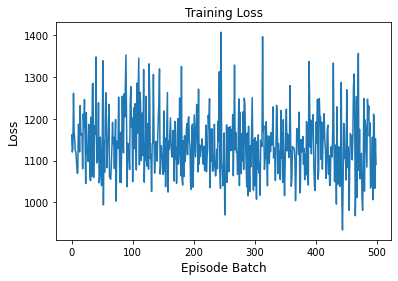

In [ ]:
# Plot of losses of model with no temp scaling and original reward
plt.plot(losses_notemp)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Training Loss")

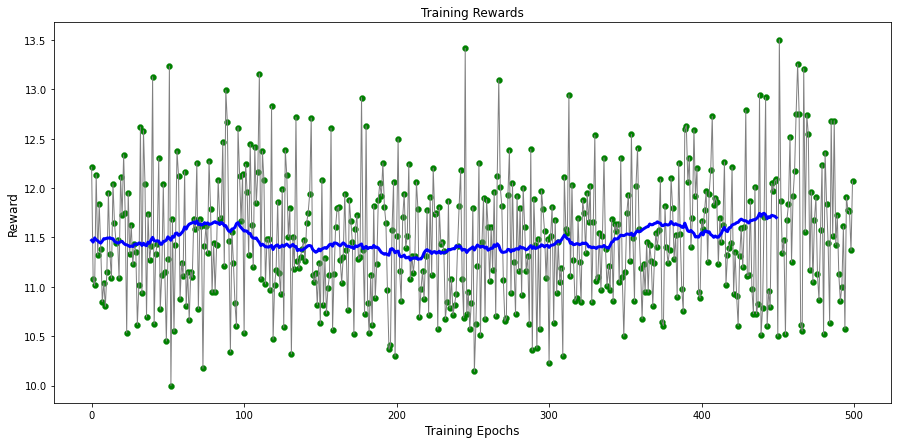

In [ ]:
# Plot of training rewards of model with no temp scaling and original reward

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(rewards_reinforce_notemp)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.title("Training Rewards")
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [ ]:
total_rewards_test_notemp = test(model_notemp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
np.mean(total_rewards_test_notemp)

11.516895474435811

Text(0.5, 1.0, 'Test Rewards')

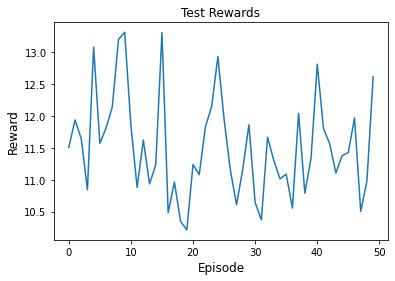

In [ ]:
plt.plot(total_rewards_test_notemp)
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Episode",fontsize=12)
plt.title("Test Rewards")

In [ ]:
# Train multi song state model without temperature scaling and original reward
model_multi_notemp = Agent()
if torch.cuda.is_available():
  model_multi_notemp.network.to(device)
losses_multi_notemp, rewards_multi_reinforce_notemp = train(model_multi_notemp, multi=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


loss:  tensor(1038.0928, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(922.5702, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(823.8309, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(924.2910, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(950.4637, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(890.6036, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(870.3989, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(991.0968, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(890.0859, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(895.6371, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1083.5833, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(878.3192, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(867.2286, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(906.0739, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(808.0716, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(821.2330, device='cuda:0

Text(0.5, 1.0, 'Training Loss')

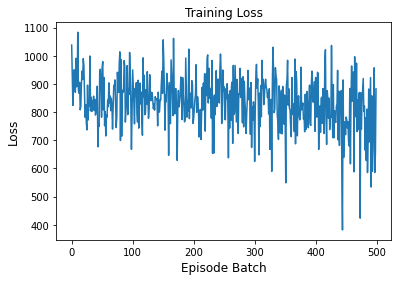

In [ ]:
# Plot of losses for multi song state model without temperature scaling and original reward
plt.plot(losses_multi_notemp)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Training Loss")

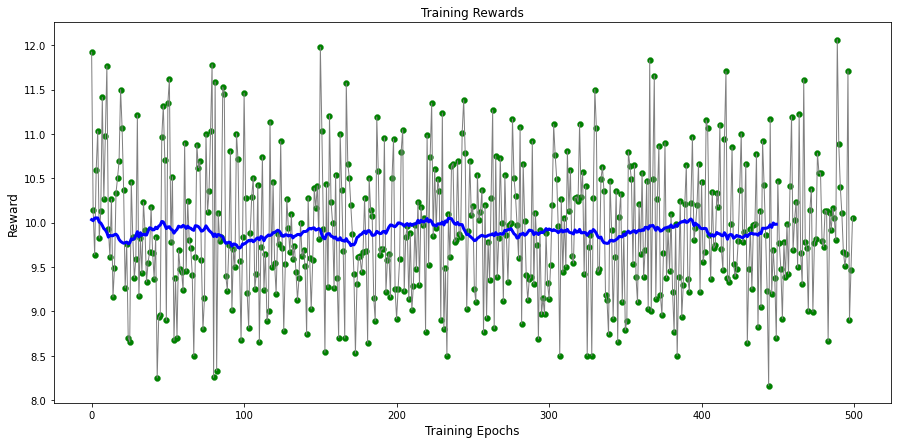

In [ ]:
# Plot of training rewards for multi song state model without 
# temperature scaling and original reward

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(rewards_multi_reinforce_notemp)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.title("Training Rewards")
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [ ]:
total_rewards_test_multi_notemp = test(model_multi_notemp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
np.mean(total_rewards_test_multi_notemp)

11.52936993561917

Text(0.5, 1.0, 'Test Rewards')

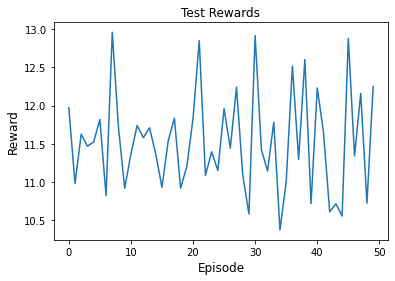

In [ ]:
plt.plot(total_rewards_test_multi_notemp)
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Episode",fontsize=12)
plt.title("Test Rewards")

# Episode Training with Temperature Original Reward

In [ ]:
# Train single song state model with temperature scaling and original reward
model = Agent()
if torch.cuda.is_available():
  model.network.to(device)
losses, rewards_reinforce = train(model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


loss:  tensor(1237.8379, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1023.7644, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1154.8293, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1239.1814, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1132.8048, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1087.2253, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1195.0017, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1051.0007, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1098.1178, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1141.1821, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1109.5713, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1334.5261, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1154.7267, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1144.7020, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1139.6885, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1133.2529, 

Text(0.5, 1.0, 'Training Loss')

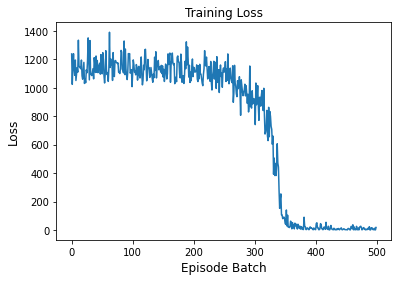

In [ ]:
# Plot of losses for single song state model with temperature scaling and original reward
plt.plot(losses)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Training Loss")

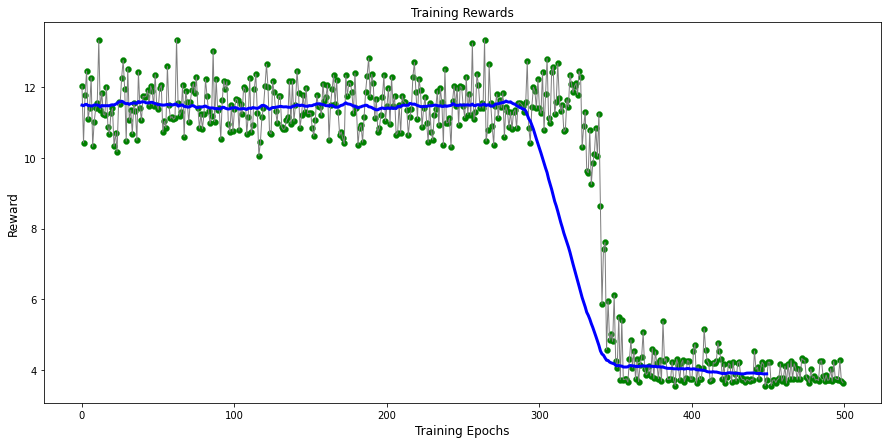

In [ ]:
# Plot of training rewards single song state model 
# with temperature scaling and original reward

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(rewards_reinforce)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.title("Training Rewards")
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [ ]:
total_rewards_test = test(model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
np.mean(total_rewards_test)

4.818514096472723

Text(0.5, 1.0, 'Test Rewards')

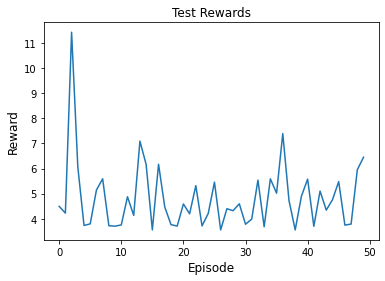

In [ ]:
plt.plot(total_rewards_test)
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Episode",fontsize=12)
plt.title("Test Rewards")

In [ ]:
# Train multi song state model with temperature scaling and original reward

model_multi = Agent()
if torch.cuda.is_available():
  model_multi.network.to(device)
losses_multi, rewards_reinforce_multi = train(model_multi, multi=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


loss:  tensor(1196.6616, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1240.9215, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1010.8171, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1077.9446, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1105.8281, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1066.1652, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1190.8579, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1485.3064, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1094.0646, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1083.5774, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1057.8594, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1139.0049, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1312.9373, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1108.8096, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1206.7256, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(1078.8761, 

Text(0.5, 1.0, 'Training Loss')

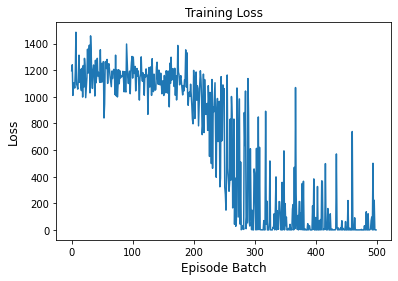

In [ ]:
# Plot of losses multi song state model with temperature scaling and original reward
plt.plot(losses_multi)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Training Loss")

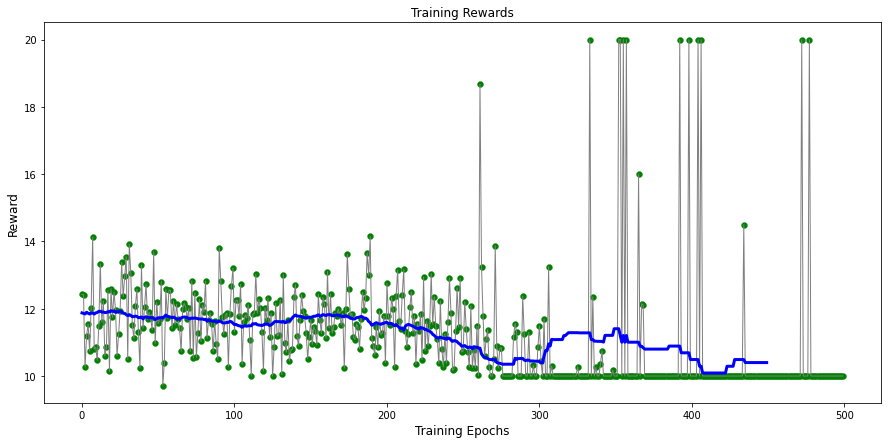

In [ ]:
# Plot of training rewards multi song statedd   uwith temperature scaling and original reward

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(rewards_reinforce_multi)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.title("Training Rewards")
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [ ]:
total_rewards_test_multi = test(model_multi)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
np.mean(total_rewards_test_multi)

11.134145156746927

Text(0.5, 1.0, 'Test Rewards')

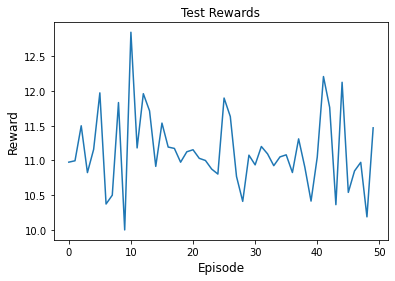

In [ ]:
plt.plot(total_rewards_test)
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Episode",fontsize=12)
plt.title("Test Rewards")

# Episode Train with Temperature and New Reward

In [ ]:
# Train single song state model with temperature scaling and not-skip reward
model_multi_prob_reward = Agent()
if torch.cuda.is_available():
  model_multi_prob_reward.network.to(device)
losses_prob_reward, rewards_reinforce_prob_reward = train(model_multi_prob_reward)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


loss:  tensor(323.5349, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(191.7493, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(409.2496, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(146.0258, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(270.3731, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(248.6826, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(373.1688, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(145.1834, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(310.9625, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(223.7303, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(281.7111, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(195.9558, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(335.7627, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(447.2740, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(197.7252, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(413.8820, device='cuda:0',

Text(0.5, 1.0, 'Training Loss')

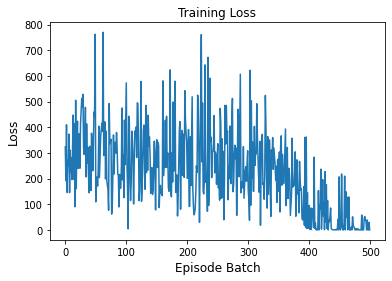

In [ ]:
# Plot losses single song state model with temperature scaling and not-skip prob reward
plt.plot(losses_prob_reward)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Training Loss")

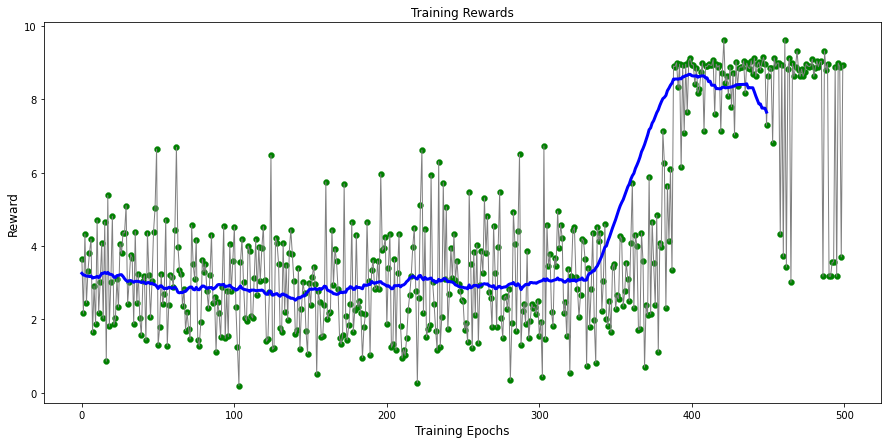

In [ ]:
# Plot training rewards of single song state 
# model with temperature scaling and not-skip prob reward

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(rewards_reinforce_prob_reward)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.title("Training Rewards")
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [ ]:
# Calculate rewards for test sessions
total_rewards_test_prob = test(model_multi_prob_reward)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Calculate average reward for test sessions
np.mean(total_rewards_test_prob)

5.331674897392361

Text(0.5, 1.0, 'Test Rewards')

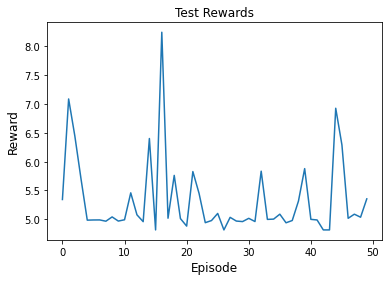

In [ ]:
# Plot test rewards
plt.plot(total_rewards_test_prob)
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Episode",fontsize=12)
plt.title("Test Rewards")

In [ ]:
# Train multi song state model with temperature scaling and not-skip prob reward
model_multireal_prob_reward = Agent()
if torch.cuda.is_available():
  model_multireal_prob_reward.network.to(device)
losses_multi_real, rewards_reinforce_multi_real = train(model_multireal_prob_reward, multi=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


loss:  tensor(417.5238, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(306.4463, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(243.6018, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(285.1971, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(91.7122, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(478.0685, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(429.8682, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(439.5515, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(786.8265, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(411.9851, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(595.0811, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(274.2960, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(261.1984, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(119.0118, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(93.6259, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(573.9114, device='cuda:0', g

Text(0.5, 1.0, 'Training Loss')

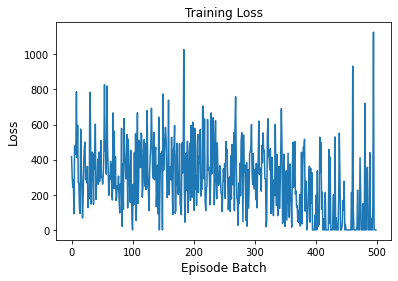

In [ ]:
# Plot losses of single song state model with temperature scaling and not-skip prob reward
plt.plot(losses_multi_real)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Training Loss")

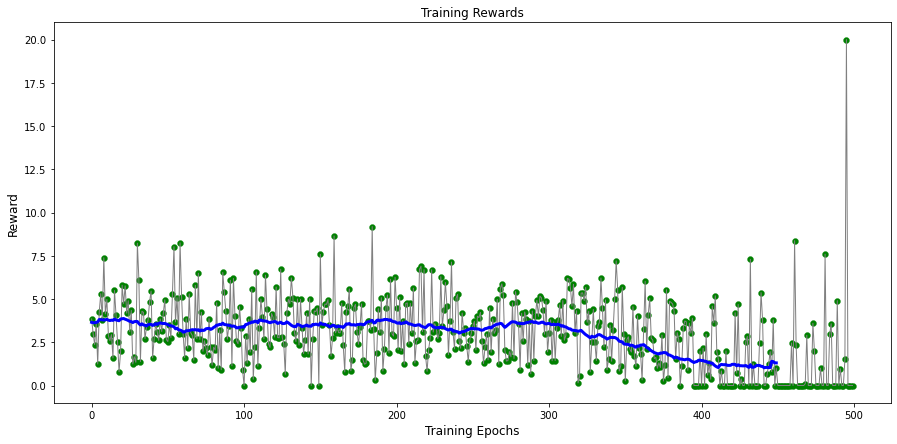

In [ ]:
# Plot training rewards of single song state 
# model with temperature scaling and not-skip prob reward


def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(rewards_reinforce_multi_real)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.title("Training Rewards")
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [ ]:
# Calculate rewards for test sessions
total_rewards_test_prob_multi = test(model_multireal_prob_reward)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Calculate average reward of test sessions
np.mean(total_rewards_test_prob_multi)

2.7771492452407314

Text(0.5, 1.0, 'Test Rewards')

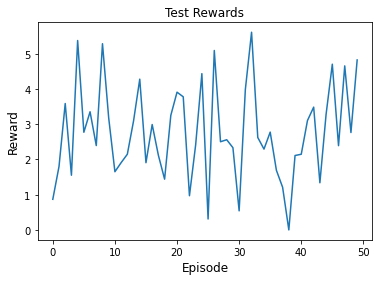

In [ ]:
# Plot rewards of test session
plt.plot(total_rewards_test_prob_multi)
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Episode",fontsize=12)
plt.title("Test Rewards")

# Batch Train
Kept to show static loss

In [ ]:
model_multi = Agent()
if torch.cuda.is_available():
  model_multi.network.to(device)
losses_multi, rewards_reinforce_multi = train(model_multi, multi=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Ep: 10 Average of last 10: 10.39
Ep: 10 Average of last 10 Skips: 2.22
Loss:  52.557125091552734
model saved
Ep: 20 Average of last 10: 10.10
Ep: 20 Average of last 10 Skips: 1.67
Loss:  51.47793197631836
model saved
Ep: 30 Average of last 10: 9.99
Ep: 30 Average of last 10 Skips: 1.33
Loss:  50.442718505859375
model saved
Ep: 40 Average of last 10: 9.74
Ep: 40 Average of last 10 Skips: 1.56
Loss:  49.749839782714844
model saved
Ep: 50 Average of last 10: 10.37
Ep: 50 Average of last 10 Skips: 1.33
Loss:  53.0806770324707
model saved
Ep: 60 Average of last 10: 10.48
Ep: 60 Average of last 10 Skips: 2.44
Loss:  53.081790924072266
model saved
Ep: 70 Average of last 10: 10.13
Ep: 70 Average of last 10 Skips: 2.00
Loss:  50.91196060180664
model saved
Ep: 80 Average of last 10: 10.31
Ep: 80 Average of last 10 Skips: 2.56
Loss:  51.654911041259766
model saved
Ep: 90 Average of last 10: 10.42
Ep: 90 Average of last 10 Skips: 1.33
Loss:  52.66836166381836
model saved
Ep: 100 Average of last 10

In [ ]:
model = Agent()
if torch.cuda.is_available():
  model.network.to(device)
losses, rewards_reinforce = train(model)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


loss:  tensor(56.8067, device='cuda:0', grad_fn=<NegBackward>)
Ep: 50 Average of last 10: 11.44
Ep: 50 Average of last 10 Skips: 2.18
Loss:  56.80672836303711
model saved
loss:  tensor(57.6514, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(57.0615, device='cuda:0', grad_fn=<NegBackward>)
Ep: 100 Average of last 10: 11.47
Ep: 100 Average of last 10 Skips: 2.22
Loss:  57.0615234375
model saved
loss:  tensor(57.5134, device='cuda:0', grad_fn=<NegBackward>)
Ep: 150 Average of last 10: 11.38
Ep: 150 Average of last 10 Skips: 2.00
Loss:  57.51344680786133
model saved
loss:  tensor(56.2580, device='cuda:0', grad_fn=<NegBackward>)
loss:  tensor(55.8904, device='cuda:0', grad_fn=<NegBackward>)
Ep: 200 Average of last 10: 11.31
Ep: 200 Average of last 10 Skips: 1.71
Loss:  55.890350341796875
model saved
loss:  tensor(56.4696, device='cuda:0', grad_fn=<NegBackward>)
Ep: 250 Average of last 10: 11.36
Ep: 250 Average of last 10 Skips: 2.02
Loss:  56.46957015991211
model saved
loss:  tensor(

# A2C Training


Code for this section was modeled based off of the implementation found here: https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f

In [64]:
# Implementation of the A2C algorithm to train the actor and critic and 
# find an optimal policy.
def train_a2c(actor, critic, episodes=500, batch_size=1, gamma=0.99, entropy_beta=0.0001, temp=1, multi=False):
  total_rewards = []
  losses_actor = []
  losses_critic = []

  state_batch = []
  action_log_probs_batch = []
  value_batch = []
  q_vals_batch = []
  reward_batch = []
  entropy_batch = []
  batch_i = 0
  ep = 1

  # Initialzie optimizers for actor and critic
  optimizer_actor = optim.Adam(actor.network.parameters(), lr=0.0003)
  optimizer_critic = optim.Adam(critic.network.parameters(), lr=0.0003)

  while ep <= episodes:
    if ep != 0 and ep % 30 == 0 and temp != 0.1:
      temp -= 0.05
    states = []
    actions_log_probs = []
    values = []
    rewards = []
    entropy_values = []
    entropy_value = 0

    i = random.randint(0,len(training_set_numeric)-1)
    if multi:
      state_multi = training_set_numeric_multi[i,:,:]
      state = torch.sum(state_multi, dim=0)
    else: 
      state = training_set_numeric[i]

    if torch.cuda.is_available():
          state = state.to(device)

    # Run simulation for 20 songs
    for song_i in range(20):
      prob_dist = actor.forward(state).to(device)
      prob_dist = torch.div(prob_dist, temp)
      # Action probabilities
      prob_dist = F.softmax(prob_dist, dim=0)
      # State value
      value = critic.forward(state).to(device)

      # Select an action to take
      action_index = torch.multinomial(prob_dist, 1).item()
      # Take the log of the probability for the chosen action
      action_log_prob = torch.log(prob_dist[action_index])
  
      # Calculate entropy for regularization
      entropy = -(prob_dist * torch.log(prob_dist)).sum()
      entropy_value += entropy

      # Get the not-skip probability for given state-action pair
      not_skip_prob = get_not_skip_prob(state, action_index)
      #diversity_val = get_song_dist_reward(state, action_index)

      # Set reward
      #reward = (0.5 * not_skip_prob) + (0.5 * diversity_val)
      reward = not_skip_prob

      states.append(state.cpu().detach().numpy())
      actions_log_probs.append(action_log_prob)
      entropy_values.append(entropy_value)
      values.append(value)
      rewards.append(reward)

      if multi:
        state = torch.cat((state_multi.unsqueeze(0)[:,1:,:], track_data_std_tensor[action_index].unsqueeze(0).unsqueeze(0)), dim=1)
        state = torch.sum(state_multi, dim=0)
      else:
        state = track_data_std_tensor[action_index].to(device)
      #song_index = action_index
      

    # Calculate Q values to use in Advantage calculation
    q_val = critic.forward(state).to(device)
    q_val_item = q_val.item()

    q_values = [0] * len(values)
    for step in reversed(range(len(rewards))):
      q_val_item = rewards[step] + gamma * q_val_item
      q_values[step] = q_val_item

    
    reward_batch.extend(rewards)
    state_batch.extend(states)
    action_log_probs_batch.extend(actions_log_probs)
    value_batch.extend(values)
    q_vals_batch.extend(q_values)
    entropy_batch.extend(entropy_values)

    batch_i += 1
    total_rewards.append(sum(rewards))
    
    # If batch is complete, update network
    if batch_i == batch_size:
        optimizer_actor.zero_grad()
        optimizer_critic.zero_grad()

        state_tensor = torch.FloatTensor(state_batch)
        reward_tensor = torch.FloatTensor(reward_batch)
        action_log_probs_tensor = torch.stack(action_log_probs_batch)
        value_tensor = torch.stack(value_batch)
        q_vals_tensor = torch.FloatTensor(q_vals_batch)
        entropy_tensor = torch.FloatTensor(entropy_batch)


        if torch.cuda.is_available():
          state_tensor = state_tensor.to(device)
          reward_tensor = reward_tensor.to(device)
          action_log_probs_tensor = action_log_probs_tensor.to(device)
          value_tensor = value_tensor.to(device)
          q_vals_tensor = q_vals_tensor.to(device)
          entropy_tensor = entropy_tensor.to(device)
        
        # Calculate advantage values for episode
        advantage = q_vals_tensor - value_tensor

        # Calculate actor and critic loss
        loss_actor = (-action_log_probs_tensor * advantage).mean()
        loss_entropy = entropy_tensor.mean()
        loss_actor = loss_actor + (entropy_beta * loss_entropy)
        loss_critic = advantage.pow(2).mean()

      
        losses_actor.append(loss_actor.item())
        losses_critic.append(loss_critic.item())

        print("loss actor: ", loss_actor)
        print("loss critic: ", loss_critic)
        # Calculate gradients
        loss_actor.backward(retain_graph=True)
        loss_critic.backward()

        # Clip gradients
        #clip_grad_norm_(actor.network.parameters(), 1.0)
        #clip_grad_norm_(critic.network.parameters(), 1.0)
        # Apply gradients
        optimizer_actor.step()
        optimizer_critic.step()
        
        state_batch = []
        action_log_probs_batch = []
        value_batch = []
        q_vals_batch = []
        reward_batch = []
        entropy_batch = []
        batch_i = 0

    avg_rewards = np.mean(total_rewards[-50:-1])
    # Print running average
    if (ep % 50 == 0):
      print("Ep: {} Average of last 50: {:.2f}".format(ep, avg_rewards), end="\n")
      print("Actor Loss: ", loss_actor)
      print("Critic Loss: ", loss_critic)
      print("model saved")
      torch.save({
            'epoch': ep,
            'actor_loss': loss_actor,
            'actor_state_dict': actor.network.state_dict(),
            'optimizer_state_dict': optimizer_actor.state_dict(),
            }, "/content/drive/My Drive/Senior_Project/models/model_trained_actor_train_temp_multi_batch")
      torch.save({
          'epoch': ep,
          'critic_loss': loss_critic,
          'actor_state_dict': critic.network.state_dict(),
          'optimizer_state_dict': optimizer_critic.state_dict(),
          }, "/content/drive/My Drive/Senior_Project/models/model_trained_critic_train_temp_multi_batch")
    ep += 1
    i += 1


  return losses_actor, losses_critic, total_rewards


In [72]:
# Calculate rewards for test sessions
def test_a2c(actor):
  total_rewards = []
  i = random.randint(0,len(training_set_numeric)-1)
  state = test_set_numeric[0].to(device)
  for i in range(50):
    state = test_set_numeric[i].to(device)
    rewards = []
    for song_i in range(20):
      output = model.forward(state).to(device)
      output = F.softmax(output)

      action_index = torch.argmax(output).item()
    
      reward = get_not_skip_prob(state, action_index)
    

      rewards.append(reward)
      
      state = track_data_std_tensor[action_index].to(device)

    total_rewards.append(sum(rewards))

  return total_rewards



# Episode Train A2C Temp

In [ ]:
# Train single song state model with temperature scaling and not-skip prob reward
actor_temp = Actor()
critic_temp = Critic()
if torch.cuda.is_available():
  actor_temp.network.to(device)
  critic_temp.network.to(device)
losses_actor_temp, losses_critic_temp, rewards_a2c_temp = train_a2c(actor_temp, critic_temp)

new batch
loss actor:  tensor(16.0837, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(3.6177, device='cuda:0', grad_fn=<MeanBackward0>)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


new batch
loss actor:  tensor(13.6654, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(2.8026, device='cuda:0', grad_fn=<MeanBackward0>)
new batch
loss actor:  tensor(10.3044, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
new batch
loss actor:  tensor(2.2181, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(0.1598, device='cuda:0', grad_fn=<MeanBackward0>)
new batch
loss actor:  tensor(16.5181, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(2.9616, device='cuda:0', grad_fn=<MeanBackward0>)
new batch
loss actor:  tensor(30.6462, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(8.7088, device='cuda:0', grad_fn=<MeanBackward0>)
new batch
loss actor:  tensor(8.0730, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(1.2167, device='cuda:0', grad_fn=<MeanBackward0>)
new batch
loss actor:  tensor(23.0563, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  te

Text(0.5, 1.0, 'Actor Training Loss')

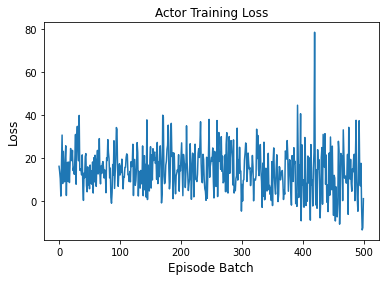

In [ ]:
# Plot losses for single song state actor with temperature scaling and not-skip prob reward
plt.plot(losses_actor_temp)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Actor Training Loss")

Text(0.5, 1.0, 'Critic Training Loss')

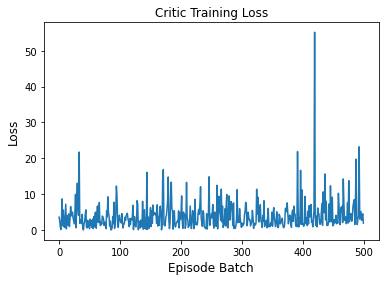

In [ ]:
# Plot losses for single song state critic with temperature scaling and not-skip prob reward

plt.plot(losses_critic_temp)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Critic Training Loss")

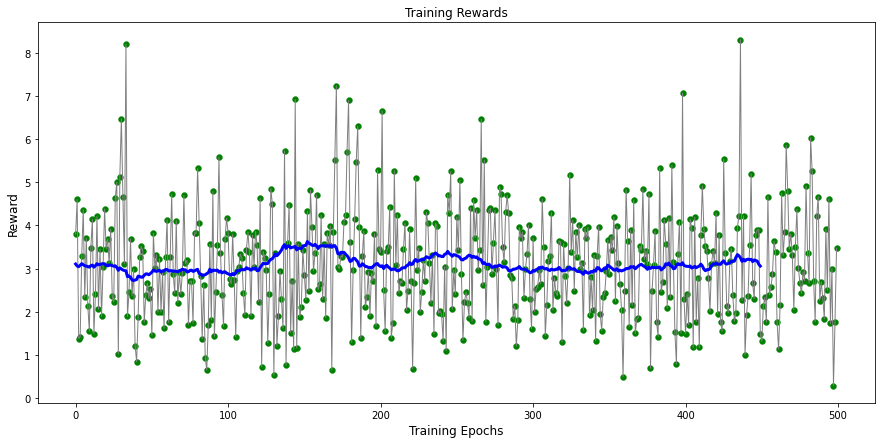

In [ ]:
# Plot training rewards for single song state 
# model with temperature scaling and not-skip prob reward

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(rewards_a2c_temp)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.title("Training Rewards")
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [ ]:
# Calculate rewards for test sessions
total_rewards_test_temp = test(actor_temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Calculate average reward for test sessions
np.mean(total_rewards_test_temp)

3.0863529985804767

Text(0.5, 1.0, 'Test Rewards')

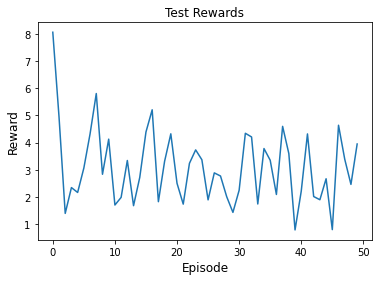

In [ ]:
# Plot rewards of test sessions
plt.plot(total_rewards_test_temp)
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Episode",fontsize=12)
plt.title("Test Rewards")

In [65]:
# Train multi song state model with temperature scaling and not-skip prob reward
actor_temp_multi = Actor()
critic_temp_multi = Critic()
if torch.cuda.is_available():
  actor_temp_multi.network.to(device)
  critic_temp_multi.network.to(device)
losses_actor_temp_multi, losses_critic_temp_multi, rewards_a2c_temp_multi = train_a2c(actor_temp_multi, critic_temp_multi, multi=True)

loss actor:  tensor(22.4287, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(5.5236, device='cuda:0', grad_fn=<MeanBackward0>)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


loss actor:  tensor(17.3928, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(3.5619, device='cuda:0', grad_fn=<MeanBackward0>)
loss actor:  tensor(23.1158, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(5.3831, device='cuda:0', grad_fn=<MeanBackward0>)
loss actor:  tensor(27.0096, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(8.9164, device='cuda:0', grad_fn=<MeanBackward0>)
loss actor:  tensor(12.1058, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(2.1229, device='cuda:0', grad_fn=<MeanBackward0>)
loss actor:  tensor(14.2374, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(2.5397, device='cuda:0', grad_fn=<MeanBackward0>)
loss actor:  tensor(3.9812, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(0.3340, device='cuda:0', grad_fn=<MeanBackward0>)
loss actor:  tensor(17.2365, device='cuda:0', grad_fn=<AddBackward0>)
loss critic:  tensor(2.8029, device='cuda:0', grad_fn=<MeanBackward0>)
loss actor:  t

Text(0.5, 1.0, 'Critic Training Loss')

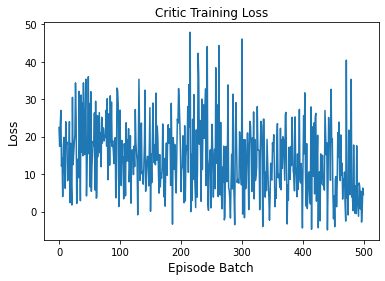

In [69]:
# Plot losses rewards for multi song state actor with temperature scaling and not-skip prob reward
plt.plot(losses_actor_temp_multi)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Critic Training Loss")

Text(0.5, 1.0, 'Critic Training Loss')

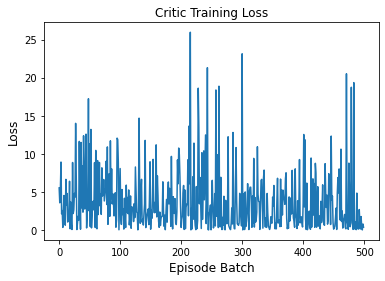

In [70]:
# Plot losses for multi song state critic with temperature scaling and not-skip prob reward
plt.plot(losses_critic_temp_multi)
plt.ylabel("Loss",fontsize=12)
plt.xlabel("Episode Batch",fontsize=12)
plt.title("Critic Training Loss")

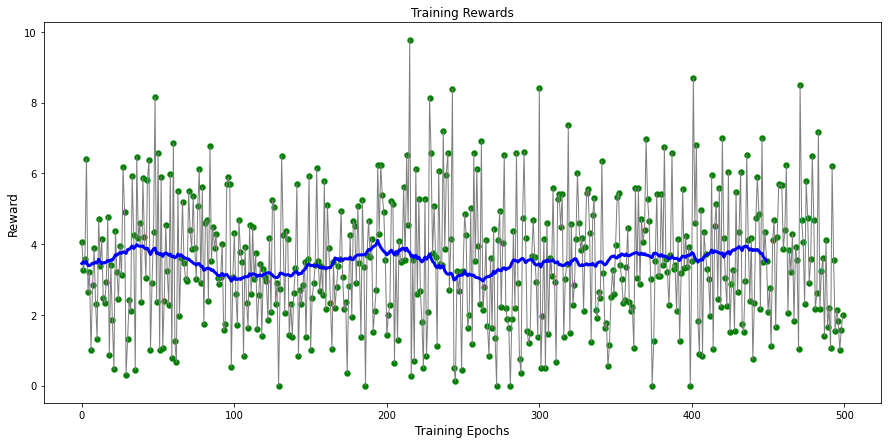

In [71]:
# Plot training rewards for multi song state 
# model with temperature scaling and not-skip prob reward

def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(rewards_a2c_temp_multi)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.title("Training Rewards")
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

In [73]:
# Calculate rewards for test sessions
total_rewards_test_temp_multi = test(actor_temp_multi)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


In [67]:
# Calculate average reward for test sessoion
np.mean(total_rewards_test_temp_multi)

2.9534297397570572

Text(0.5, 1.0, 'Test Rewards')

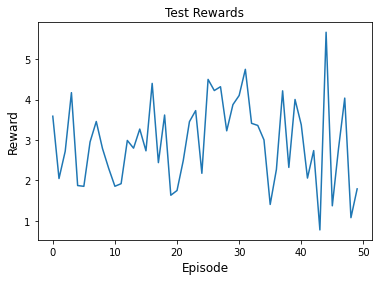

In [68]:
# Plot rewards of test sessions
plt.plot(total_rewards_test_temp_multi)
plt.ylabel("Reward",fontsize=12)
plt.xlabel("Episode",fontsize=12)
plt.title("Test Rewards")

# Batch Train A2C
Kept to show static loss

In [ ]:
actor_multi = Actor()
critic_multi = Critic()
if torch.cuda.is_available():
  actor_multi.network.to(device)
  critic_multi.network.to(device)
losses_actor_multi, losses_critic_multi, rewards_a2c_multi = train_a2c(actor_multi, critic_multi, multi=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


new batch
Ep: 10 Average of last 10: 10.79
Actor Loss:  tensor(58.5972, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(38.6634, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
Ep: 20 Average of last 10: 10.44
Actor Loss:  tensor(56.9877, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(36.3523, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
Ep: 30 Average of last 10: 10.49
Actor Loss:  tensor(57.1110, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(36.1350, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
Ep: 40 Average of last 10: 10.64
Actor Loss:  tensor(56.5844, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(36.7551, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
50
new batch
Ep: 50 Average of last 10: 10.74
Actor Loss:  tensor(58.1134, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(38.1038, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new bat

In [ ]:
actor = Actor()
critic = Critic()
optimizer_actor = optim.Adam(model.network.parameters(), lr=0.003)
optimizer_critic = optim.Adam(model.network.parameters(), lr=0.003)
checkpoint_actor = torch.load("/content/drive/My Drive/Senior_Project/models/model_trained_actor")
checkpoint_critic = torch.load("/content/drive/My Drive/Senior_Project/models/model_trained_critic")
actor.network.load_state_dict(checkpoint_actor['actor_state_dict'])
optimizer_actor.load_state_dict(checkpoint_actor['optimizer_state_dict'])
critic.network.load_state_dict(checkpoint_critic['actor_state_dict'])
optimizer_critic.load_state_dict(checkpoint_critic['optimizer_state_dict'])
if torch.cuda.is_available():
  actor.network.to(device)
  critic.network.to(device)
losses_actor, losses_critic, rewards_a2c = train_a2c(actor, critic)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


new batch
50
Ep: 50 Average of last 50: 11.82
Actor Loss:  tensor(61.9595, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(42.7241, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
new batch
100
Ep: 100 Average of last 50: 11.86
Actor Loss:  tensor(61.1218, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(41.6730, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
150
Ep: 150 Average of last 50: 12.07
Actor Loss:  tensor(62.8913, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(43.7244, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
new batch
200
Ep: 200 Average of last 50: 11.60
Actor Loss:  tensor(62.7917, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(43.0694, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
250
Ep: 250 Average of last 50: 11.73
Actor Loss:  tensor(59.7013, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(39.9026, device='cuda:0', grad

In [ ]:
actor = Actor()
critic = Critic()
if torch.cuda.is_available():
  actor.network.to(device)
  critic.network.to(device)
losses_actor, losses_critic, rewards_a2c = train_a2c(actor, critic)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


new batch
50
Ep: 50 Average of last 10: 9.38
Actor Loss:  tensor(51.0658, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(28.7437, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
new batch
100
Ep: 100 Average of last 10: 9.39
Actor Loss:  tensor(50.6226, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(28.1322, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
150
Ep: 150 Average of last 10: 9.31
Actor Loss:  tensor(50.0706, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(27.8563, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
new batch
200
Ep: 200 Average of last 10: 9.36
Actor Loss:  tensor(50.8969, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(28.4807, device='cuda:0', grad_fn=<MeanBackward0>)
model saved
new batch
250
Ep: 250 Average of last 10: 9.33
Actor Loss:  tensor(50.1024, device='cuda:0', grad_fn=<MeanBackward0>)
Critic Loss:  tensor(27.7731, device='cuda:0', grad_fn=<